1. На основе учебного ноутбука проведите финальную подготовку данных. Иизмените количество сегментирующих классов с `16` на `5`.

2. Проведите суммарно не менее `10` экспериментов и визуализируйте их результаты (включая точность обучения сетей на одинаковом количестве эпох, например, на `7`):

  - изменив `filters` в сверточных слоях
  - изменив `kernel_size` в сверточных слоях
  - изменив активационную функцию в скрытых слоях с `relu` на `linear` или/и `selu`, `elu`.


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

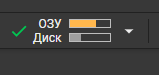



Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [ ]:
# очистка ОЗУ
import gc

# Для работы с множествами
import itertools

# Для работы с файлами
import os

# Для работы со временем
import time

# Для работы с арихивами
import zipfile

# загрузка файлов по HTML ссылке
import gdown

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем библиотеку numpy
import numpy as np

# Для работы с таблицами
import pandas as pd

# Для вывода в Jupyter Notebook
from IPython.display import display

# Импортируем стандартные слои keras
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Input,
    MaxPooling2D,
    concatenate,
)

# Импортируем модели keras: Model
from tensorflow.keras.models import Model

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака
if not os.path.exists("construction_256x192.zip"):
    gdown.download(
        "https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip",
        None,
        quiet=False,
    )

# распоковываем архив
if not os.path.exists("train") or not os.path.exists("val"):
    with zipfile.ZipFile("construction_256x192.zip", "r") as zip_ref:
        zip_ref.extractall()

### Настрйока глобальных параметров

In [ ]:
# Глобальные параметры
IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT = 192              # Высота картинки
NUM_CLASSES = 5               # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

### Подготовка выборок

Загрузим оригинальные изображения (код из лекции):

In [4]:
train_images = []  # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = []  # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY + "/original")):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(
        image.load_img(
            os.path.join(TRAIN_DIRECTORY + "/original", filename),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
        )
    )

# Отображаем время загрузки картинок обучающей выборки
print(
    "Обучающая выборка загружена. Время загрузки: ",
    round(time.time() - cur_time, 2),
    "c",
    sep="",
)

# Отображаем количество элементов в обучающей выборке
print("Количество изображений: ", len(train_images))

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY + "/original")):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(
        image.load_img(
            os.path.join(VAL_DIRECTORY + "/original", filename),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
        )
    )

# Отображаем время загрузки картинок проверочной выборки
print(
    "Проверочная выборка загружена. Время загрузки: ",
    round(time.time() - cur_time, 2),
    "c",
    sep="",
)

# Отображаем количество элементов в проверочной выборке
print("Количество изображений: ", len(val_images))

Обучающая выборка загружена. Время загрузки: 0.18c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.01c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [5]:
train_segments = []  # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = []  # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

for filename in sorted(
    os.listdir(TRAIN_DIRECTORY + "/segment")
):  # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(
        image.load_img(
            os.path.join(TRAIN_DIRECTORY + "/segment", filename),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
        )
    )

# Отображаем время загрузки картинок обучающей выборки
print(
    "Обучающая выборка загружена. Время загрузки: ",
    round(time.time() - cur_time, 2),
    "c",
    sep="",
)

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print("Количество изображений: ", len(train_segments))

cur_time = time.time()  # Засекаем текущее время

for filename in sorted(
    os.listdir(VAL_DIRECTORY + "/segment")
):  # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(
        image.load_img(
            os.path.join(VAL_DIRECTORY + "/segment", filename),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
        )
    )

# Отображаем время загрузки картинок проверочной выборки
print(
    "Проверочная выборка загружена. Время загрузки: ",
    round(time.time() - cur_time, 2),
    "c",
    sep="",
)

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print("Количество изображений: ", len(val_segments))

Обучающая выборка загружена. Время загрузки: 0.18c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.01c
Количество изображений:  100
Проверочная выборка загружена. Время загрузки: 0.01c
Количество изображений:  100


## Решение


### Задание констант

In [ ]:
# Ваше решение
CLASS_LABELS_16 = (
    (100, 100, 100),  # Пол (серый)
    (0, 0, 100),  # Потолок (синий)
    (0, 100, 0),  # Стена (зеленый)
    (100, 0, 0),  # Колонна (красный)
    (0, 100, 100),  # Проем (темно-бирюзовый)
    (100, 0, 100),  # Дверь (бордовый)
    (100, 100, 0),  # Окно (золотой)
    (200, 200, 200),  # Внешний мир (светло-серый)
    (0, 200, 0),  # Перила (светло-зеленый)
    (200, 0, 0),  # Батареи (светло-красный)
    (0, 200, 200),  # Люди (бирюзовый)
    (0, 0, 200),  # Лестница (светло-синий)
    (200, 0, 200),  # Инвентарь (розовый)
    (200, 200, 0),  # Лампа (желтый)
    (0, 100, 200),  # Провод (голубой)
    (100, 0, 200),  # Балка (фиолетовый)
)
LABELS_5_CLASS = (0, 1, 2, *[3] * 9, 4, *[3] * 3) # Сокращаем до 5 классов
FLOOR = CLASS_LABELS_16[0] # Пол
CEILING = CLASS_LABELS_16[1] # Потолок
WALL = CLASS_LABELS_16[2] # Стена
INVENTORY = (200, 0, 200) # Инвентарь
OTHER = (100, 0, 0) # Другие объекты
CLASS_LABELS_5 = (FLOOR, CEILING, WALL, INVENTORY, OTHER)

### Функции преобразования RGB в метки классов и обратно

In [ ]:
def rgb_to_labels_5(image_list, class_labels=CLASS_LABELS_16, new_labels=CLASS_LABELS_5):
    # Преобразует RGB-картинки сегментации в метки классов (5 классов)
    result = []
    for d in image_list:
        sample = np.array(d)
        y = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype="uint8")

        for i, cl in enumerate(class_labels):
            # Находим пиксели с цветом cl и присваиваем им новый класс
            y[np.where(np.all(sample == class_labels[i], axis=-1))] = new_labels[i]
        result.append(y)
    return np.array(result)


def labels_5_to_rgb(image_list):
    # Преобразует метки классов обратно в RGB-картинки (5 цветов)
    result = []
    for y in image_list:
        temp = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype="uint8")
        for i, cl in enumerate(CLASS_LABELS_5):
            # Находим пиксели с меткой i и присваиваем им цвет из CLASS_LABELS_5
            temp[np.where(np.all(y == i, axis=-1))] = CLASS_LABELS_5[i]
        result.append(temp)
    return np.array(result)


### Подготовка выборок

In [ ]:
# Создание выборок для обучения и проверки
x_train = np.array([image.img_to_array(img) for img in train_images])
x_val = np.array([image.img_to_array(img) for img in val_images])

# Преобразование сегментированных изображений в метки классов (5 классов)
y_train = rgb_to_labels_5(train_segments, CLASS_LABELS_16, LABELS_5_CLASS)
y_val = rgb_to_labels_5(val_segments, CLASS_LABELS_16, LABELS_5_CLASS)

print("Форма x_train:", x_train.shape)
print("Форма x_val:", x_val.shape)
print("Форма y_train:", y_train.shape)
print("Форма y_val:", y_val.shape)


Форма x_train: (1900, 192, 256, 3)
Форма x_val: (100, 192, 256, 3)
Форма y_train: (1900, 192, 256, 1)
Форма y_val: (100, 192, 256, 1)


### Функция вывода примеров работы модели

In [ ]:
def process_images(model, count=1):
    # Функцтя для вывода результатов работы модели 
    # на случайных изображениях из валидационной выборки
    indexes = np.random.randint(0, len(x_val), count)
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)
    orig = labels_5_to_rgb(predict[..., None])

    fig, axs = plt.subplots(3, count, figsize=(25, 15))

    if count == 1:
        axs[0].set_title("Результат работы модели:")
        axs[0].imshow(orig[0])
        axs[0].axis("off")

        axs[1].set_title("Оригинальное сегментированное")
        axs[1].imshow(val_segments[indexes[0]])
        axs[1].axis("off")

        axs[2].set_title("Оригинальное изображение")
        axs[2].imshow(val_images[indexes[0]])
        axs[2].axis("off")
    else:
        for i in range(count):
            axs[0, 0].set_title("Результат работы модели:")
            axs[0, i].imshow(orig[i])
            axs[0, i].axis("off")

            axs[1, 0].set_title("Оригинальное сегментированное")
            axs[1, i].imshow(val_segments[indexes[i]])
            axs[1, i].axis("off")

            axs[2, 0].set_title("Оригинальное изображение")
            axs[2, i].imshow(val_images[indexes[i]])
            axs[2, i].axis("off")
    plt.show()


### Создание и обучение моделей

In [ ]:
def masked_unet(
    CLASS_COUNT, input_shape, filters=64, kernel_size=(3, 3), activation="relu"
):
    # Входной слой
    img_input = Input(input_shape)

    # Первый блок свертки
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_1 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Второй блок свертки
    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_2 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Третий блок свертки
    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_3 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Четвертый блок свертки
    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_4 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Пятый блок свертки
    x = Conv2D(filters * 16, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 16, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)

    # Блок декодирования
    x = Conv2DTranspose(
        filters * 8, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)

    # Первый блок декодирования
    x = BatchNormalization()(x)
    x = concatenate([x, x_4])
    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)

    # Второй блок декодирования
    x = Conv2DTranspose(
        filters * 4, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)
    x = BatchNormalization()(x)
    x = concatenate([x, x_3])
    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)

    # Третий блок декодирования
    x = Conv2DTranspose(
        filters * 2, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)
    x = BatchNormalization()(x)
    x = concatenate([x, x_2])
    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)

    # Четвертый блок декодирования
    x = Conv2DTranspose(
        filters, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)
    x = BatchNormalization()(x)
    x = concatenate([x, x_1])
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)

    # Выходной слой
    x = Conv2D(CLASS_COUNT, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)

    model = Model(img_input, x)  # Создаем модель
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )  # Компилируем модель
    return model


Создание списков параметров моделей

In [ ]:
filters_list = [32, 64]
kernel_size_list = [(3, 3), (7, 7)]
activation_list = ["relu", "linear", "selu"]

experiment_results = []

EPOCHS = 10

Цикл создания и обучения моделей с различными параметрами

In [ ]:
for filters, kernel_size, activation in itertools.product(
    filters_list, kernel_size_list, activation_list
):
    print(
        f"\nЭксперимент с filters={filters}, kernel_size={kernel_size}, activation='{activation}'"
    )

    model_masked_unet = masked_unet(
        NUM_CLASSES,
        (IMG_HEIGHT, IMG_WIDTH, 3),
        filters=filters,
        kernel_size=kernel_size,
        activation=activation,
    )  # Создаем модель

    history = model_masked_unet.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=16,
        validation_data=(x_val, y_val),
        verbose=1,
    )  # Обучаем модель

    train_accuracy = history.history["sparse_categorical_accuracy"][-1]
    val_accuracy = history.history["val_sparse_categorical_accuracy"][-1]
    del model_masked_unet
    del history

    gc.collect()

    experiment_results.append(
        {
            "filters": filters,
            "kernel_size": kernel_size,
            "activation": activation,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
        }
    )  # Добавляем результаты экспериментов


Эксперимент с filters=32, kernel_size=(3, 3), activation='relu'


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - loss: 1.4053 - sparse_categorical_accuracy: 0.4700 - val_loss: 78.1390 - val_sparse_categorical_accuracy: 0.3603
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.8524 - sparse_categorical_accuracy: 0.6977 - val_loss: 2.6209 - val_sparse_categorical_accuracy: 0.5242
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.7401 - sparse_categorical_accuracy: 0.7350 - val_loss: 1.4806 - val_sparse_categorical_accuracy: 0.6497
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.7493 - val_loss: 1.4731 - val_sparse_categorical_accuracy: 0.5996
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.6598 - sparse_categorical_accuracy: 0.7599 - val_loss: 1.2071 - val_sparse_categorical_accuracy: 0.6013
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.6144 - sparse_categorical_accuracy: 0.7762 - val_loss: 0.9552 - val_sparse_categorical_accuracy: 0.

### Вывод сравнительной таблицы

In [ ]:
results_df = pd.DataFrame(experiment_results)
display(results_df)

,filters,kernel_size,activation,train_accuracy,val_accuracy
0,32,"(3, 3)",relu,0.806657,0.689092
1,32,"(3, 3)",linear,0.728444,0.635474
2,32,"(3, 3)",selu,0.800199,0.571713
3,32,"(7, 7)",relu,0.771031,0.544441
4,32,"(7, 7)",linear,0.702281,0.621223
5,32,"(7, 7)",selu,0.761336,0.607680
6,64,"(3, 3)",relu,0.799453,0.419250
7,64,"(3, 3)",linear,0.714001,0.610479
8,64,"(3, 3)",selu,0.790500,0.681658
9,64,"(7, 7)",relu,0.765020,0.565912
